# Definitions (run first!)

In [1]:
import gzip
import pickle
import random
import requests
import csv
from torch.utils.data import Dataset, DataLoader
from mitnewsclassify.gpt_model import GPTModel as GPTHead
from transformers import GPT2Tokenizer, GPT2Model
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42

In [3]:
class GPTEmbeddedDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx

In [4]:
import csv

def loadcsv(filename):
    with open(filename, newline='', encoding='utf-8') as f:
        return list(csv.reader(f))

def load_label_map(out2id_path, id2label_path):
    
    out2id = loadcsv(out2id_path)
    out2id = {int(row[0]): row[1] for row in out2id}

    id2label_raw = loadcsv(id2label_path)
    id2label = {}

    for row in id2label_raw:
        if row == []:
            continue
        id2label[row[1]] = row[2]

    out2label = [id2label[out2id[out]] for out in sorted(out2id.keys())]
    
    return out2label

out2label = load_label_map('labels_dict_gpt.csv', 'nyt-theme-tags.csv')
mlb = MultiLabelBinarizer(classes=out2label)
mlb.fit(out2label)

MultiLabelBinarizer(classes=['suspensions, dismissals and resignations',
                             'education and schools',
                             'colleges and universities', 'blacks',
                             'population', 'economic conditions and trends',
                             'labor',
                             'office buildings and commercial properties',
                             'architecture', 'medicine and health',
                             'awards, decorations and honors',
                             'diseases and conditions', 'research', 'cancer',
                             'basketball', 'design', 'interior design',
                             'real estate', 'trades (sports)',
                             'demonstrations and riots', 'dancing',
                             'hockey, ice', 'games', 'playoff games',
                             'baseball', 'travel and vacations', 'finances',
                             'books and literature',
   

In [5]:
# temporary dataset for storing tokenized articles & transformed labels
class NYTDataset(Dataset):
    def __init__(self, articles, labels):

        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token

        print('Tokenizing...')
        self.articles = self.tokenizer(articles, add_special_tokens=True, padding="max_length", truncation=True,
                                       max_length=1024, return_tensors="pt", return_attention_mask=True)

        self.input_ids = self.articles['input_ids']
        self.attention_mask = self.articles['attention_mask']

        print('Preprocessing labels...')
        self.labels = mlb.transform(labels)
        print('Done')

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        # return self.articles[idx], self.labels[idx]
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]

# Load, Pre-process & Embed data with GPT2 & Save to disk

In [7]:
# open the train data given to us by Max
with gzip.open('../../NYTcorpus_train.p.gz', mode='r') as f:
    train_data = pickle.load(f)

# open the test data given to us by Max
with gzip.open('../../NYTcorpus_test.p.gz', mode='r') as f:
    test_data = pickle.load(f)

# shuffle just in case the test and train data were not shuffled before - 
# we will only measure model's accuracy on a few thousand samples
random.Random(seed).shuffle(train_data)
random.Random(seed).shuffle(test_data)

# train and test data labels are coded in numbers,
# but the models predict human-readable labels,
# so we need to re-map these. 
# Let's use one of the files downloaded by the mitnewsclassify package
with open('nyt-theme-tags.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    tags_dict = {row['tags_id']: row['tag'] for row in reader}

# extract actual article texts from data samples
train_articles = [d[2] for d in train_data] 
test_articles = [d[2] for d in test_data]

# map the number-coded labels to human-readable labels
train_labels_lists = [list(map(tags_dict.get, d[3:])) for d in train_data]
test_labels_lists = [list(map(tags_dict.get, d[3:])) for d in test_data]

In [8]:
# takes 2-3 minutes

train_size = 100_000
test_size = 10_000

train_dataset = NYTDataset(train_articles[:train_size], train_labels_lists[:train_size])
test_dataset = NYTDataset(test_articles[:test_size], test_labels_lists[:test_size])

Tokenizing...
Preprocessing labels...
Done
Tokenizing...
Preprocessing labels...
Done


In [6]:
train_dataset = torch.load('train_dataset_tokenized_eos_pad.pt')
test_dataset = torch.load('test_dataset_tokenized_eos_pad.pt')
toy_dataset = torch.load('toy_dataset_tokenized_eos_pad.pt')

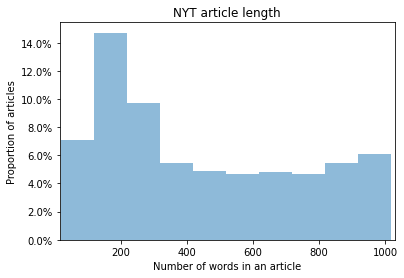

In [7]:
# plot article length histogram

lens = torch.ne(train_dataset.articles['input_ids'], train_dataset.tokenizer.pad_token_id).sum(-1)

import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

# fixed bin size
bins = np.arange(math.ceil(min(lens)), math.floor(max(lens)), 100) # fixed bin size

plt.xlim([min(lens)-5, max(lens)+5])

plt.hist(lens.numpy(), bins=bins, alpha=0.5, weights=np.ones(len(lens)) / len(lens))
plt.title('NYT article length')
plt.xlabel('Number of words in an article')
plt.ylabel('Proportion of articles')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [8]:
n_relevant_len = np.sum((np.array(lens) > 500) & (np.array(lens) < 1024))
print(f'Articles with 500 < length < 1024 (train set): {n_relevant_len/len(lens) * 100:.2f}%')

Articles with 500 < length < 1024 (train set): 26.75%


### Careful, cell below takes a long time!

In [14]:
from torch.utils.data import Subset

toy_samples = torch.arange(0,128)
toy_dataset = Subset(train_dataset, toy_samples)

In [19]:
torch.save(train_dataset, 'train_dataset_inter.pt')
torch.save(test_dataset, 'test_dataset_inter.pt')
torch.save(toy_dataset, 'toy_dataset_inter.pt')

In [9]:
from tqdm.notebook import tqdm

runs = [(train_dataset, 'gpt_embedded_train_100k_gpt2_medium.pt'), (test_dataset, 'gpt_embedded_test_100k_gpt2_medium.pt')]
# runs = [(toy_dataset, 'gpt_embedded_train_toy.pt')]

print('Loading model...')
model = GPT2Model.from_pretrained('gpt2-medium')

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(train_dataset.tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)

batch_size = 1

for dataset, output_path in runs:

    iterator = DataLoader(dataset, batch_size=batch_size)
    print(f'Preprocessing dataset for ', output_path)

    X_train = []
    y_train = []

    # for some weird reason,
    # I couldn't make DataLoader work with NYTDataset
    # so will just go through the dataset 1 by 1
    for i, batch in enumerate(tqdm(iterator)):
        inputs, attention_mask, labels = batch

        real_batch_size = inputs.shape[0]

        inputs = inputs.to(device)
        attention_mask = attention_mask.to(device)
        labels = torch.tensor(labels).to(device)

        with torch.no_grad():
            output = model(input_ids=inputs, attention_mask=attention_mask)

        output = output[0]

        # indices of last non-padded elements in each sequence
        # adopted from https://github.com/huggingface/transformers/blob/master/src/transformers/models/gpt2/modeling_gpt2.py#L1290-L1302
        last_non_padded_ids = torch.ne(inputs, test_dataset.tokenizer.pad_token_id).sum(-1) - 1

        article_embeddings = output[range(real_batch_size), last_non_padded_ids, :].detach().cpu()

        X_train += article_embeddings
        y_train += labels.detach().cpu()

    saved_dataset = GPTEmbeddedDataset(torch.stack(X_train), torch.stack(y_train))
    torch.save(saved_dataset, output_path)
    print('Done!')

Loading model...
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'h.12.attn.masked_bias', 'h.13.attn.masked_bias', 'h.14.attn.masked_bias', 'h.15.attn.masked_bias', 'h.16.attn.masked_bias', 'h.17.attn.masked_bias', 'h.18.attn.masked_bias', 'h.19.attn.masked_bias', 'h.20.attn.masked_bias', 'h.21.attn.masked_bias', 'h.22.attn.masked_bias', 'h.23.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Preprocessing dataset for  gpt_embedded_train_100k_gpt2_medium.pt


  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-9-10cb4f784e12>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Done!
Preprocessing dataset for  gpt_embedded_test_100k_gpt2_medium.pt


  0%|          | 0/10000 [00:00<?, ?it/s]

Done!


In [13]:
torch.stack(X_train).shape

torch.Size([10000, 768])

In [22]:
torch.stack(X_train).shape

torch.Size([128, 768])

In [17]:
torch.cuda.empty_cache()